In [6]:
import os
import math
import time

import h5py
import matplotlib.pyplot as plt
import mlflow
import numpy as np
from numpy.random import choice
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
from torch.optim import SGD, Optimizer, Adam, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from tqdm.auto import tqdm as tq
from craterdetection.detection.loss_functions.dice import f_score, BCEDiceLoss, SoftDiceLoss, dice_coefficient

from craterdetection.detection.deepmoon import DeepMoon
from craterdetection.detection.loss_functions.tversky import TverskyLoss
from craterdetection.detection.unetmini import UNetMini
from craterdetection.detection.training import CraterDataset, RAdam

from craterdetection.detection.loss_functions.lovasz import LovaszHingeLoss

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [8]:
dataset_path = "../data/dataset_nadir.h5"
train_dataset = CraterDataset(dataset_path, "training")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

validation_dataset = CraterDataset(dataset_path, "validation")
validation_loader = DataLoader(validation_dataset, batch_size=32, num_workers=0)

test_dataset = CraterDataset(dataset_path, "test")
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True, num_workers=0)

In [12]:
model = DeepMoon(sigmoid=False)
pretrained = True
if pretrained:
    model.load_state_dict(torch.load("../blobs/DeepMoon.pth"))

# optimizer = RMSprop(model.parameters(), lr=1e-5, weight_decay=1e-7, momentum=0.4)
optimizer = SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-9, dampening=0.1)
# optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
# optimizer = RAdam(model.parameters(), lr=1e-4)
# loss_function = SoftDiceLoss()
# loss_function = nn.BCEWithLogitsLoss()
loss_function = BCEDiceLoss(lambda_bce=1.0, lambda_dice=1.0)
# loss_function = TverskyLoss(alpha=0.1, beta=0.9)
# loss_function = LovaszHingeLoss()

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True, cooldown=2)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True, factor=0.5)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

model.to(device)
loss_function.to(device)

BCEDiceLoss(
  (bce): BCEWithLogitsLoss()
  (dice): SoftDiceLoss()
)

In [15]:
tracked_params = ('lr', 'momentum', 'weight_decay', 'dampening')

num_epochs = 10

name = "Filled" if "filled" in dataset_path else "Edge"
name += " | Pretrained" if pretrained else " | Untrained"

with mlflow.start_run(run_name=name):

    mlflow.log_param('optimizer', type(optimizer).__name__)
    mlflow.log_param('loss_function', type(loss_function).__name__)
    mlflow.log_param('dataset', os.path.basename(dataset_path))
    try:
        mlflow.log_param('lambda_dice', loss_function.lambda_dice)
        mlflow.log_param('lambda_bce', loss_function.lambda_bce)
    except AttributeError as err:
        pass

    try:
        mlflow.log_param('tversky_alpha', loss_function.alpha)
        mlflow.log_param('tversky_beta', loss_function.beta)
    except AttributeError as err:
        pass

    for tp in tracked_params:
        try:
            mlflow.log_param(tp, optimizer.state_dict()['param_groups'][0][tp])
        except KeyError as err:
            pass

    train_loss_list = []
    valid_loss_list = []
    dice_score_list = []

    for e in range(1, num_epochs+1):
        print(f'\n-----Epoch {e} started-----\n')

        since = time.time()

        train_loss, valid_loss, dice_score = 0, 0, 0

        model.train()

        bar = tq(train_loader, desc=f"Training [{e}]", postfix={"train_loss": 0.0})
        for batch, (images, masks) in enumerate(bar, 1):
            images, masks = images.to(device), masks.to(device)

            with autocast():
                pred = model(images)
                loss = loss_function(pred, masks)

            optimizer.zero_grad()

            loss.backward()
            train_loss += loss.item() * images.size(0)

            optimizer.step()
            bar.set_postfix(ordered_dict={"train_loss": loss.item()})

        train_loss = train_loss/len(train_loader.dataset)
        train_loss_list.append(train_loss)
        mlflow.log_metric("train_loss", train_loss, step=e)

        model.eval()
        del images, masks
        with torch.no_grad():
            bar = tq(validation_loader, desc=f"Validation [{e}]", postfix={"valid_loss": 0.0, "dice_score": 0.0})
            for images, masks in bar:
                images, masks = images.to(device), masks.to(device)

                with autocast():
                    pred = model(images)
                    loss = loss_function(pred, masks)

                if not isinstance(loss_function, SoftDiceLoss):
                    dice_coeff = dice_coefficient(pred, masks).item()
                else:
                    dice_coeff = 1-loss.item()

                valid_loss += loss.item()
                dice_score += dice_coeff
                bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_coeff})
        # calculate average losses
        valid_loss = valid_loss/len(validation_loader)
        valid_loss_list.append(valid_loss)

        dice_score = dice_score/len(validation_loader)
        dice_score_list.append(dice_score)

        mlflow.log_metric("valid_loss", valid_loss, step=e)
        mlflow.log_metric("dice_score", dice_score, step=e)

        time_elapsed = time.time() - since
        scheduler.step(valid_loss)

        print(
            f"\nSummary:\n",
            f"\tEpoch: {e}/{num_epochs}\n",
            f"\tAverage train loss: {train_loss}\n",
            f"\tAverage validation loss: {valid_loss}\n",
            f"\tAverage Dice score: {dice_score}\n",
            f"\tDuration: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
        )
        print(f'-----Epoch {e} finished.-----\n')



-----Epoch 1 started-----



Training [1]:   0%|          | 0/313 [00:00<?, ?it/s, train_loss=0]

Validation [1]:   0%|          | 0/16 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch     3: reducing learning rate of group 0 to 5.0000e-05.

Summary:
 	Epoch: 1/10
 	Average train loss: 1.3032699600219726
 	Average validation loss: 1.1774855330586433
 	Average Dice score: 0.056604143464937806
 	Duration: 4m 49s
-----Epoch 1 finished.-----


-----Epoch 2 started-----



Training [2]:   0%|          | 0/313 [00:00<?, ?it/s, train_loss=0]

Validation [2]:   0%|          | 0/16 [00:00<?, ?it/s, dice_score=0, valid_loss=0]


Summary:
 	Epoch: 2/10
 	Average train loss: 1.9719145837783814
 	Average validation loss: 1.1760535463690758
 	Average Dice score: 0.05581917311064899
 	Duration: 4m 50s
-----Epoch 2 finished.-----


-----Epoch 3 started-----



Training [3]:   0%|          | 0/313 [00:00<?, ?it/s, train_loss=0]

Validation [3]:   0%|          | 0/16 [00:00<?, ?it/s, dice_score=0, valid_loss=0]


Summary:
 	Epoch: 3/10
 	Average train loss: 1.1510504642486572
 	Average validation loss: 1.1393078193068504
 	Average Dice score: 0.04775368864648044
 	Duration: 4m 51s
-----Epoch 3 finished.-----


-----Epoch 4 started-----



Training [4]:   0%|          | 0/313 [00:00<?, ?it/s, train_loss=0]

Validation [4]:   0%|          | 0/16 [00:00<?, ?it/s, dice_score=0, valid_loss=0]


Summary:
 	Epoch: 4/10
 	Average train loss: 1.46070594997406
 	Average validation loss: 1.2119621559977531
 	Average Dice score: 0.057100893231108785
 	Duration: 4m 54s
-----Epoch 4 finished.-----


-----Epoch 5 started-----



Training [5]:   0%|          | 0/313 [00:00<?, ?it/s, train_loss=0]

Validation [5]:   0%|          | 0/16 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch     7: reducing learning rate of group 0 to 2.5000e-05.

Summary:
 	Epoch: 5/10
 	Average train loss: 1.1719225748062134
 	Average validation loss: 1.1644877716898918
 	Average Dice score: 0.05482692993246019
 	Duration: 4m 48s
-----Epoch 5 finished.-----


-----Epoch 6 started-----



Training [6]:   0%|          | 0/313 [00:00<?, ?it/s, train_loss=0]

KeyboardInterrupt: 

Mean: 0.0, StD: 0.1, Min: 0.0, Max: 1.0


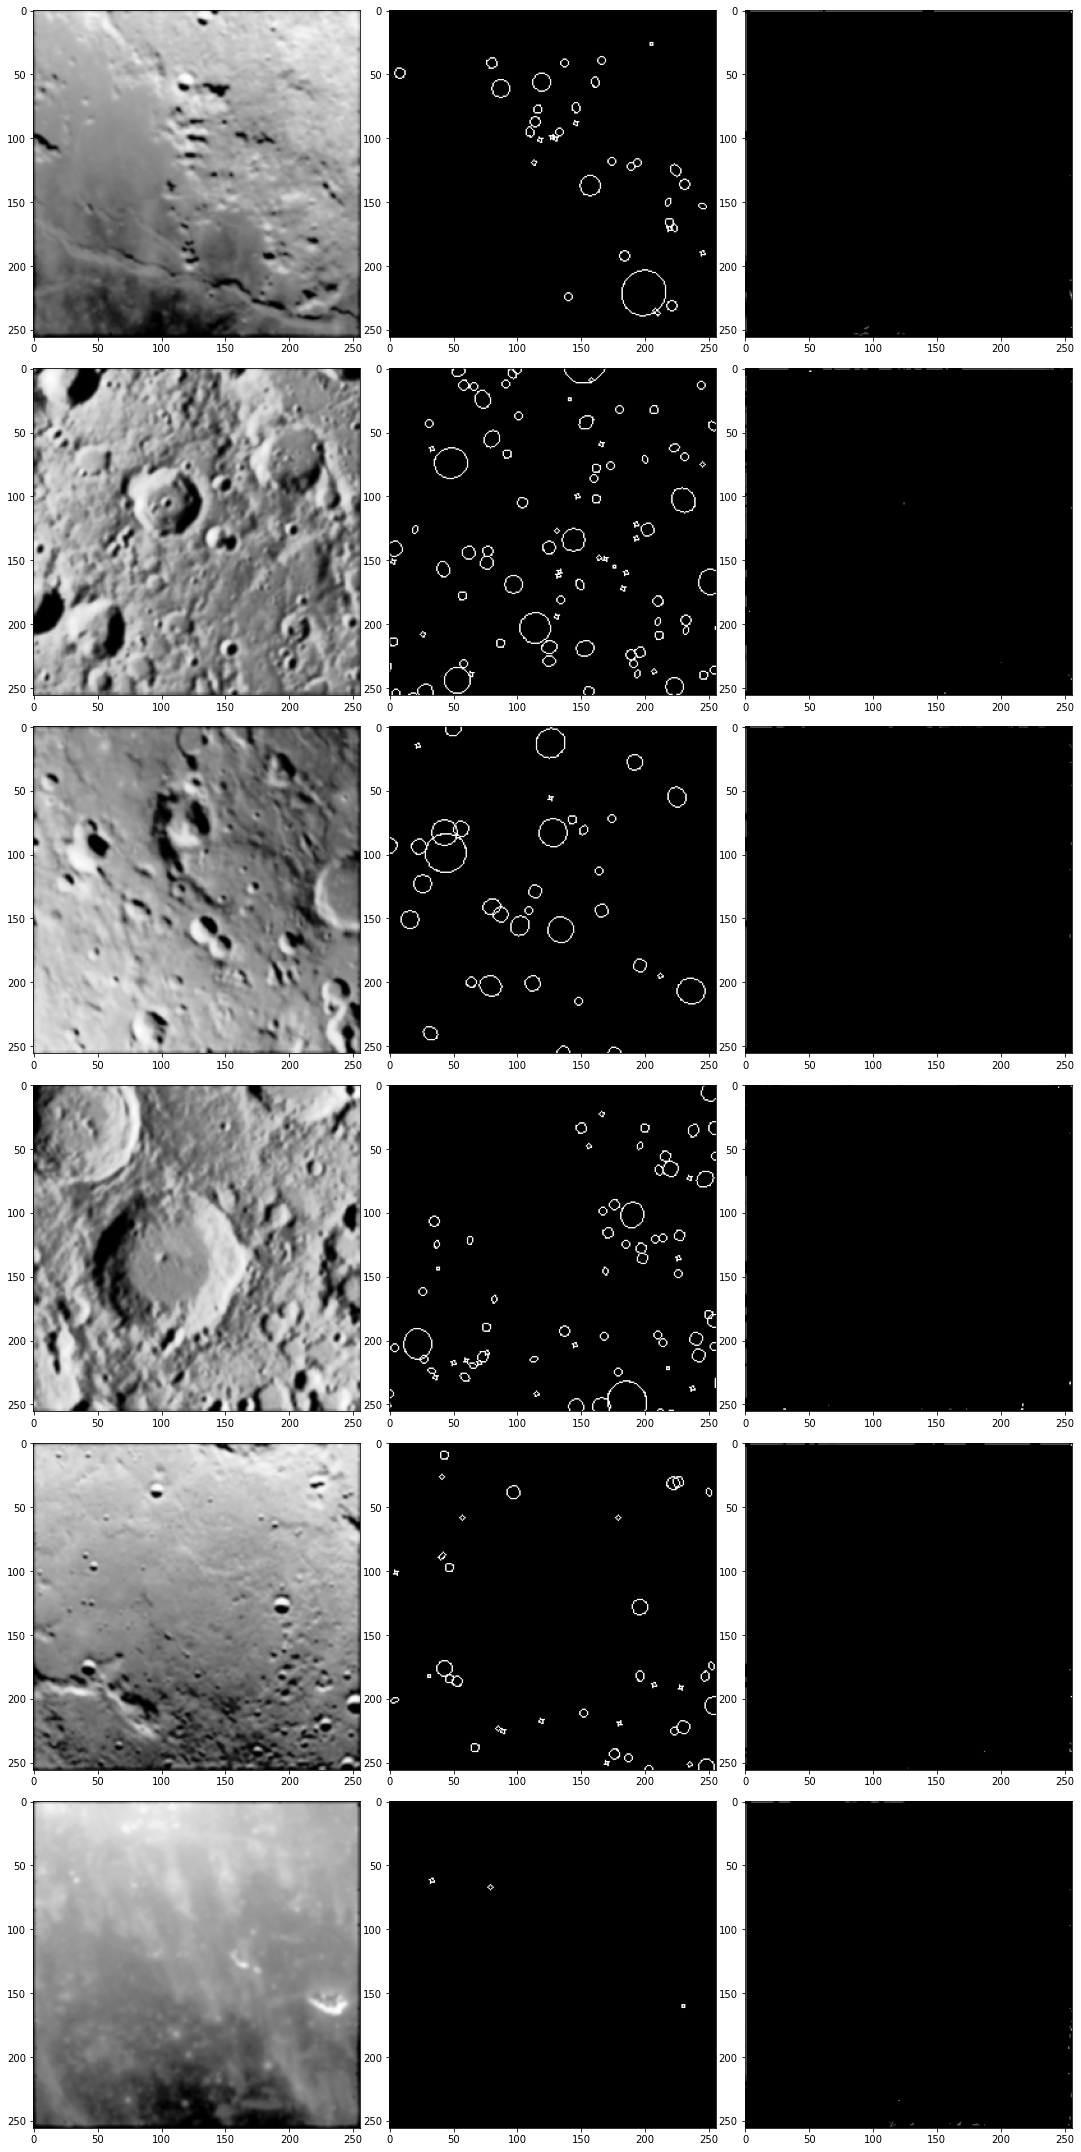

In [16]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)
model.eval()
with torch.no_grad():
    out = model(images).sigmoid()
    print(f"Mean: {out.mean().item():.1f}, StD: {out.std().item():.1f}, Min: {out.min().item():.1f}, Max: {out.max().item():.1f}")
    out = nn.Threshold(0.175, 0)(out)*255
    # out = out.clamp(0., 1)

fig, axes = plt.subplots(6, 3, figsize=(15, 30))

for i in range(6):
    axes[i, 0].imshow(images[i, 0].cpu().numpy(), cmap='Greys_r')
    axes[i, 1].imshow(masks[i, 0].cpu().numpy(), cmap='Greys_r')
    axes[i, 2].imshow(out[i, 0].cpu().numpy(), cmap='Greys_r')
fig.tight_layout()

In [ ]:
model.eval()
test_loss, dice_score, f1, f1_ = 0, 0, 0, 0
with torch.no_grad():
    bar = tq(test_loader, postfix={"test_loss": 0.0, "dice_score": 0.0, "f_score": 0.0})
    for images, masks in bar:
        images, masks = images.to(device), masks.to(device)

        with autocast():
            pred = model(images)
            loss = loss_function(pred, masks)

        test_loss += loss.item()*images.size(0)
        dice_cof = dice_coefficient(pred.sigmoid(), masks).item()
        dice_score += dice_cof * pred.size(0)
        f1 = f_score(pred.sigmoid(), images).item() * images.size(0)
        f1_ += f1
        bar.set_postfix(ordered_dict={"test_loss":loss.item(), "dice_score":dice_cof, "f_score": f1})

    test_loss /= len(test_loader.dataset)
    dice_score /= len(test_loader.dataset)
    f1_ /= len(test_loader.dataset)
print(f"test_loss: {test_loss} \ndice_score: {dice_score} \nf_score: {f1}")